In [453]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
import matplotlib.pyplot as plt
init_notebook_mode(connected=False)
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, plot_confusion_matrix

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

## Import Data

In [521]:
#import data 
df = pd.read_csv('Space_Corrected.csv')
df.head()

Unnamed: 0  Unnamed: 0.1 Company Name  \
0           0             0       SpaceX   
1           1             1         CASC   
2           2             2       SpaceX   
3           3             3    Roscosmos   
4           4             4          ULA   

                                            Location  \
0         LC-39A, Kennedy Space Center, Florida, USA   
1  Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...   
2                      Pad A, Boca Chica, Texas, USA   
3       Site 200/39, Baikonur Cosmodrome, Kazakhstan   
4           SLC-41, Cape Canaveral AFS, Florida, USA   

                        Datum                                        Detail  \
0  Fri Aug 07, 2020 05:12 UTC  Falcon 9 Block 5 | Starlink V1 L9 & BlackSky   
1  Thu Aug 06, 2020 04:01 UTC           Long March 2D | Gaofen-9 04 & Q-SAT   
2  Tue Aug 04, 2020 23:57 UTC            Starship Prototype | 150 Meter Hop   
3  Thu Jul 30, 2020 21:25 UTC  Proton-M/Briz-M | Ekspress-80 & Ekspress-103   
4  Thu Jul 30, 2020 11:50 UTC                    Atlas V 541 | Perseverance   

  Status Rocket  Rocket Status Mission  
0  StatusActive   50.0         Success  
1  StatusActive  29.75         Success  
2  StatusActive     NaN        Success  
3  StatusActive   65.0         Success  
4  StatusActive  145.0         Success

In [522]:
#drop data unnamed
df.drop(['Unnamed: 0.1','Unnamed: 0'], axis=1, inplace = True)
df.head()

Company Name                                           Location  \
0       SpaceX         LC-39A, Kennedy Space Center, Florida, USA   
1         CASC  Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...   
2       SpaceX                      Pad A, Boca Chica, Texas, USA   
3    Roscosmos       Site 200/39, Baikonur Cosmodrome, Kazakhstan   
4          ULA           SLC-41, Cape Canaveral AFS, Florida, USA   

                        Datum                                        Detail  \
0  Fri Aug 07, 2020 05:12 UTC  Falcon 9 Block 5 | Starlink V1 L9 & BlackSky   
1  Thu Aug 06, 2020 04:01 UTC           Long March 2D | Gaofen-9 04 & Q-SAT   
2  Tue Aug 04, 2020 23:57 UTC            Starship Prototype | 150 Meter Hop   
3  Thu Jul 30, 2020 21:25 UTC  Proton-M/Briz-M | Ekspress-80 & Ekspress-103   
4  Thu Jul 30, 2020 11:50 UTC                    Atlas V 541 | Perseverance   

  Status Rocket  Rocket Status Mission  
0  StatusActive   50.0         Success  
1  StatusActive  29.75         Success  
2  StatusActive     NaN        Success  
3  StatusActive   65.0         Success  
4  StatusActive  145.0         Success

Deskripsi Data
- **Company Name** - Nama Perusahaan
- **Location** - Lokasi Peluncuran
- **Datum** - Tanggal Peluncuran
- **Detail** - Nama Rocket
- **Status Rocket** - Status Rocket
- **Rocket** - Biaya yang dibutuhkan dalam millions
- **Status Mission** - Status Misi

## Extract Data

In [523]:
# Check Nilai NaN didalam data
check_null_data = df.isnull() 
i=0
for column in df.columns.values.tolist(): 
    if (df[column].isnull().values.any() == True):
        print(column)
        print(check_null_data[column].value_counts()) #menjumlah jumlah nilai unique di dataset
        print("")
        i=1

if (i==0):
    print('Tidak ada nilai NaN dalam dataframe')

 Rocket
True     3360
False     964
Name:  Rocket, dtype: int64



Nilai NaN dibiarkan karena jika di drop, akan menghilangkan data data penting lainnya. dan nilai ini tidak bisa diganti oleh mean median dan sebagainya

In [524]:
# Mengambil nilai negara pada kolom Location
country = df['Location'].str.split(',', expand=True)
print (country.head())
df['country'] = country[2]

# Mengambil nilai stasiun penerbangan roket
df['stasiun'] = country[1]

                   0                                 1            2     3
0             LC-39A              Kennedy Space Center      Florida   USA
1  Site 9401 (SLS-2)   Jiuquan Satellite Launch Center        China  None
2              Pad A                        Boca Chica        Texas   USA
3        Site 200/39               Baikonur Cosmodrome   Kazakhstan  None
4             SLC-41                Cape Canaveral AFS      Florida   USA


In [525]:
# Mengambil nilai tahun, bulan dan hari
df['Datum'] = pd.to_datetime(df['Datum'], utc=True)
df['year'], df['month'], df['days'] = df['Datum'].dt.year, df['Datum'].dt.month, df['Datum'].dt.day

In [526]:
# Mengambil nama jenis rocket
jenis = df['Detail'].str.split('-', expand=True)
jenis = jenis[0]
jenis = jenis.str.split(expand=True)
jenis = jenis[0]
df['Type']=jenis

In [527]:
df.head()

Company Name                                           Location  \
0       SpaceX         LC-39A, Kennedy Space Center, Florida, USA   
1         CASC  Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...   
2       SpaceX                      Pad A, Boca Chica, Texas, USA   
3    Roscosmos       Site 200/39, Baikonur Cosmodrome, Kazakhstan   
4          ULA           SLC-41, Cape Canaveral AFS, Florida, USA   

                      Datum                                        Detail  \
0 2020-08-07 05:12:00+00:00  Falcon 9 Block 5 | Starlink V1 L9 & BlackSky   
1 2020-08-06 04:01:00+00:00           Long March 2D | Gaofen-9 04 & Q-SAT   
2 2020-08-04 23:57:00+00:00            Starship Prototype | 150 Meter Hop   
3 2020-07-30 21:25:00+00:00  Proton-M/Briz-M | Ekspress-80 & Ekspress-103   
4 2020-07-30 11:50:00+00:00                    Atlas V 541 | Perseverance   

  Status Rocket  Rocket Status Mission      country  \
0  StatusActive   50.0         Success      Florida   
1  StatusActive  29.75         Success        China   
2  StatusActive     NaN        Success        Texas   
3  StatusActive   65.0         Success   Kazakhstan   
4  StatusActive  145.0         Success      Florida   

                            stasiun  year  month  days      Type  
0              Kennedy Space Center  2020      8     7    Falcon  
1   Jiuquan Satellite Launch Center  2020      8     6      Long  
2                        Boca Chica  2020      8     4  Starship  
3               Baikonur Cosmodrome  2020      7    30    Proton  
4                Cape Canaveral AFS  2020      7    30     Atlas

In [528]:
df.drop(['Location','Datum','Detail'], axis=1, inplace = True)
df.head()

Company Name Status Rocket  Rocket Status Mission      country  \
0       SpaceX  StatusActive   50.0         Success      Florida   
1         CASC  StatusActive  29.75         Success        China   
2       SpaceX  StatusActive     NaN        Success        Texas   
3    Roscosmos  StatusActive   65.0         Success   Kazakhstan   
4          ULA  StatusActive  145.0         Success      Florida   

                            stasiun  year  month  days      Type  
0              Kennedy Space Center  2020      8     7    Falcon  
1   Jiuquan Satellite Launch Center  2020      8     6      Long  
2                        Boca Chica  2020      8     4  Starship  
3               Baikonur Cosmodrome  2020      7    30    Proton  
4                Cape Canaveral AFS  2020      7    30     Atlas

In [529]:
#Check Unique setiap kolom

for column in df.columns.values.tolist(): 
    print(column)
    print(df[column].unique())
    print('  ')

Company Name
['SpaceX' 'CASC' 'Roscosmos' 'ULA' 'JAXA' 'Northrop' 'ExPace' 'IAI'
 'Rocket Lab' 'Virgin Orbit' 'VKS RF' 'MHI' 'IRGC' 'Arianespace' 'ISA'
 'Blue Origin' 'ISRO' 'Exos' 'ILS' 'i-Space' 'OneSpace' 'Landspace'
 'Eurockot' 'Land Launch' 'CASIC' 'KCST' 'Sandia' 'Kosmotras' 'Khrunichev'
 'Sea Launch' 'KARI' 'ESA' 'NASA' 'Boeing' 'ISAS' 'SRC' 'MITT' 'Lockheed'
 'AEB' 'Starsem' 'RVSN USSR' 'EER' 'General Dynamics' 'Martin Marietta'
 'Yuzhmash' 'Douglas' 'ASI' 'US Air Force' 'CNES' 'CECLES' 'RAE' 'UT'
 'OKB-586' 'AMBA' "Arm??e de l'Air" 'US Navy']
  
Status Rocket
['StatusActive' 'StatusRetired']
  
 Rocket
['50.0 ' '29.75 ' nan '65.0 ' '145.0 ' '64.68 ' '48.5 ' '90.0 ' '46.0 '
 '28.3 ' '29.15 ' '7.5 ' '30.8 ' '5.3 ' '12.0 ' '112.5 ' '120.0 ' '153.0 '
 '200.0 ' '85.0 ' '115.0 ' '41.8 ' '21.0 ' '31.0 ' '40.0 ' '164.0 '
 '62.0 ' '37.0 ' '350.0 ' '39.0 ' '47.0 ' '35.0 ' '69.7 ' '109.0 ' '45.0 '
 '123.0 ' '130.0 ' '25.0 ' '56.5 ' '15.0 ' '29.0 ' '80.0 ' '140.0 '
 '55.0 ' '59.5 ' '450.0

In [530]:
# mengganti beberapa nama negara agar seusai
dict_country = {
    'Russian Federation' : 'Russia',
    'New Mexico' : 'USA',
    "Yellow Sea": 'China',
    "Shahrud Missile Test Site": "Iran",
    "Pacific Missile Range Facility": 'USA',
    "Barents Sea": 'Russian Federation',
    "Gran Canaria": 'USA',
    "Florida": 'USA',
    "Texas": 'USA',
    "Virginia": 'USA',
    "California": 'USA',
    "French Guiana": 'French',
}
df['Country'] = df['country'].replace(dict_country, regex=True)
df['Country'].unique()

array([' USA', ' China', ' Kazakhstan', ' Japan', ' Israel',
       ' New Zealand', None, ' Russia', ' French', ' Iran', ' India',
       ' North Korea', ' Pacific Ocean', ' South Korea',
       ' Marshall Islands', ' Alaska', ' Russian Federation',
       ' Maranh?œo', ' Kenya', ' Australia', ' Algeria'], dtype=object)

In [531]:
df.drop(['country'], axis=1, inplace = True)

In [532]:
df['Country'] = df['Country'].replace(np.nan, 'Other')

In [533]:
df['Country'].unique()

array([' USA', ' China', ' Kazakhstan', ' Japan', ' Israel',
       ' New Zealand', 'Other', ' Russia', ' French', ' Iran', ' India',
       ' North Korea', ' Pacific Ocean', ' South Korea',
       ' Marshall Islands', ' Alaska', ' Russian Federation',
       ' Maranh?œo', ' Kenya', ' Australia', ' Algeria'], dtype=object)

In [534]:
df.head()

Company Name Status Rocket  Rocket Status Mission  \
0       SpaceX  StatusActive   50.0         Success   
1         CASC  StatusActive  29.75         Success   
2       SpaceX  StatusActive     NaN        Success   
3    Roscosmos  StatusActive   65.0         Success   
4          ULA  StatusActive  145.0         Success   

                            stasiun  year  month  days      Type      Country  
0              Kennedy Space Center  2020      8     7    Falcon          USA  
1   Jiuquan Satellite Launch Center  2020      8     6      Long        China  
2                        Boca Chica  2020      8     4  Starship          USA  
3               Baikonur Cosmodrome  2020      7    30    Proton   Kazakhstan  
4                Cape Canaveral AFS  2020      7    30     Atlas          USA

## Analysis Data

### Distribusi Status Misi

In [535]:
count = df['Status Mission'].value_counts()
count = count [0:3]

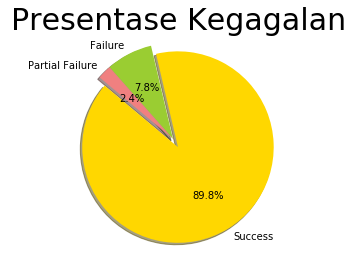

<Figure size 432x288 with 0 Axes>

In [585]:
explode = (0.1, 0, 0)  # explode 1st slice
labels = count.index
colors = ['gold', 'yellowgreen', 'lightcoral']

plt.pie(count, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.title('Presentase Kegagalan',fontsize=30)
plt.axis('equal')
plt.show()

plt.savefig('plot/presentase.png', transparent=True, bbox_inches='tight')

### Plot Distribusi Negara

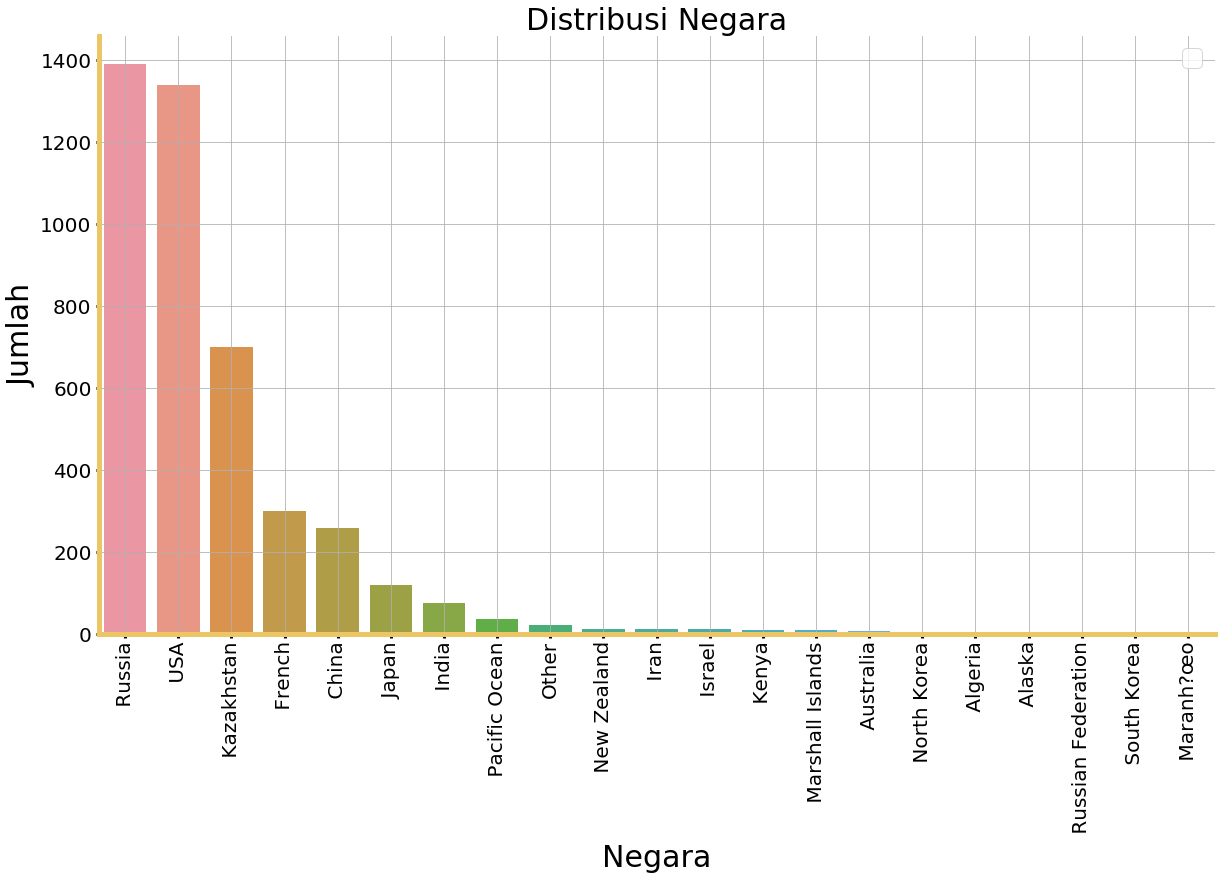

In [586]:
# Count Plot Country
fig1 = plt.figure(figsize=(20,11))
ax = fig1

ax = sns.countplot(x = 'Country', data = df ,order = df['Country'].value_counts().index)

plt.xticks(rotation='vertical')

ax.set_xlabel('Negara', fontsize = 30)
ax.set_ylabel('Jumlah', fontsize = 30)
ax.set_title('Distribusi Negara',fontsize=30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

ax.legend(prop={'size': 25})
ax.grid(True)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('#ecc664')
ax.spines['bottom'].set_color('#ecc664')
ax.xaxis.set_tick_params(width=3)
ax.yaxis.set_tick_params(width=3)
plt.setp(ax.spines.values(), linewidth=5)

plt.xticks(rotation='vertical')
ax.set_title('Distribusi Negara',fontsize=30)
fig1.savefig('plot/dist_negara.png', transparent=True, bbox_inches='tight')
plt.show()

### Plot Status Misi Terhadap Negara

In [539]:
mean_fail = df.groupby(['Country', 'Status Mission']).size().unstack(fill_value=0)
mean_fail['Total'] = mean_fail.sum(axis=1)
for i in range (0,4):
    mean_fail.iloc[:,i] = mean_fail.iloc[:,i]/mean_fail['Total'] *100
mean_fail

Status Mission         Failure  Partial Failure  Prelaunch Failure  \
Country                                                              
 Alaska               0.000000         0.000000           0.000000   
 Algeria              0.000000        25.000000           0.000000   
 Australia           50.000000         0.000000           0.000000   
 China                6.563707         2.316602           0.000000   
 French               4.347826         1.337793           0.000000   
 India               10.526316         6.578947           0.000000   
 Iran                61.538462         0.000000           7.692308   
 Israel              18.181818         0.000000           0.000000   
 Japan                4.201681         2.521008           0.000000   
 Kazakhstan          10.271041         2.853067           0.142653   
 Kenya                0.000000         0.000000           0.000000   
 Maranh?œo           66.666667         0.000000          33.333333   
 Marshall Islands    33.333333         0.000000           0.000000   
 New Zealand         15.384615         0.000000           0.000000   
 North Korea         60.000000         0.000000           0.000000   
 Pacific Ocean        8.333333         0.000000           0.000000   
 Russia               4.460432         2.158273           0.000000   
 Russian Federation  33.333333         0.000000           0.000000   
 South Korea         66.666667         0.000000           0.000000   
 USA                  9.410007         2.464526           0.074683   
Other                30.434783         0.000000           0.000000   

Status Mission          Success  Total  
Country                                 
 Alaska              100.000000      3  
 Algeria              75.000000      4  
 Australia            50.000000      6  
 China                91.119691    259  
 French               94.314381    299  
 India                82.894737     76  
 Iran                 30.769231     13  
 Israel               81.818182     11  
 Japan                93.277311    119  
 Kazakhstan           86.733238    701  
 Kenya               100.000000      9  
 Maranh?œo             0.000000      3  
 Marshall Islands     66.666667      9  
 New Zealand          84.615385     13  
 North Korea          40.000000      5  
 Pacific Ocean        91.666667     36  
 Russia               93.381295   1390  
 Russian Federation   66.666667      3  
 South Korea          33.333333      3  
 USA                  88.050784   1339  
Other                 69.565217     23

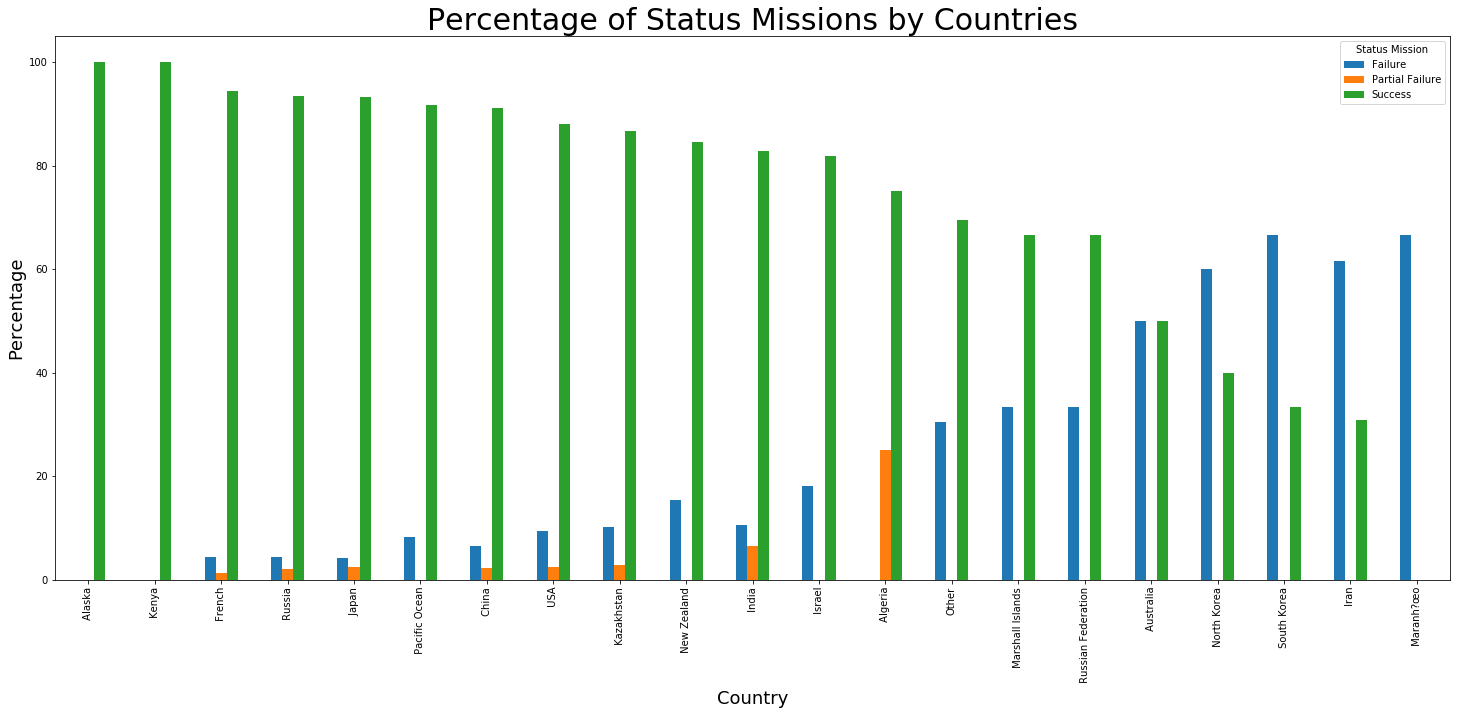

In [587]:
mean_fail = mean_fail.sort_values(ascending=False, by='Success')

ax = mean_fail.iloc[:,[0,1,3]].plot.bar(rot=0, figsize=(25,10))
plt.xticks(rotation='vertical')
ax.set_ylabel('Percentage', fontsize = 18)
ax.set_xlabel('Country', fontsize = 18)
ax.set_title('Percentage of Status Missions by Countries',fontsize=30)

plt.savefig('plot/persentase_negara.png', transparent=True, bbox_inches='tight')

### Fungsi Plot

In [588]:
def plot_mean (data):
    mean_fail2 = df.groupby([data, 'Status Mission']).size().unstack(fill_value=0)
    mean_fail2['Total'] = mean_fail2.sum(axis=1)
    for i in range (0,4):
        mean_fail2.iloc[:,i] = mean_fail2.iloc[:,i]/mean_fail2['Total'] *100
        
    mean_fail2 = mean_fail2.sort_values(ascending=False, by='Success')

    ax = mean_fail2.iloc[:,[0,1,3]].plot.bar(rot=0, figsize=(25,10))
    plt.xticks(rotation='vertical')
    plt.xticks(fontsize = 15, color='#467d93')
    ax.set_ylabel('Percentage', fontsize = 18)
    ax.set_xlabel(data, fontsize = 18)
    ax.set_title('Percentage of Status Missions'+data,fontsize=30)
    plt.savefig('plot/'+data+'.png', transparent=True, bbox_inches='tight')
    
    return

In [592]:
def plot_mean2 (data):
    fig = px.treemap(df,path = ['Status Mission','Country',data])
    fig.update_layout(template = 'ggplot2',margin=dict(l=80, r=80, t=50, b=10),
                      title = { 'text' : '<b>Mission Status,Countries and '+data+'</b>', 'x' : 0.5},
                     font_family = 'Fira Code',title_font_color= '#ff6767')
    fig.show()
    
    return

### Plot Status Misi Terhadap Perusahaan

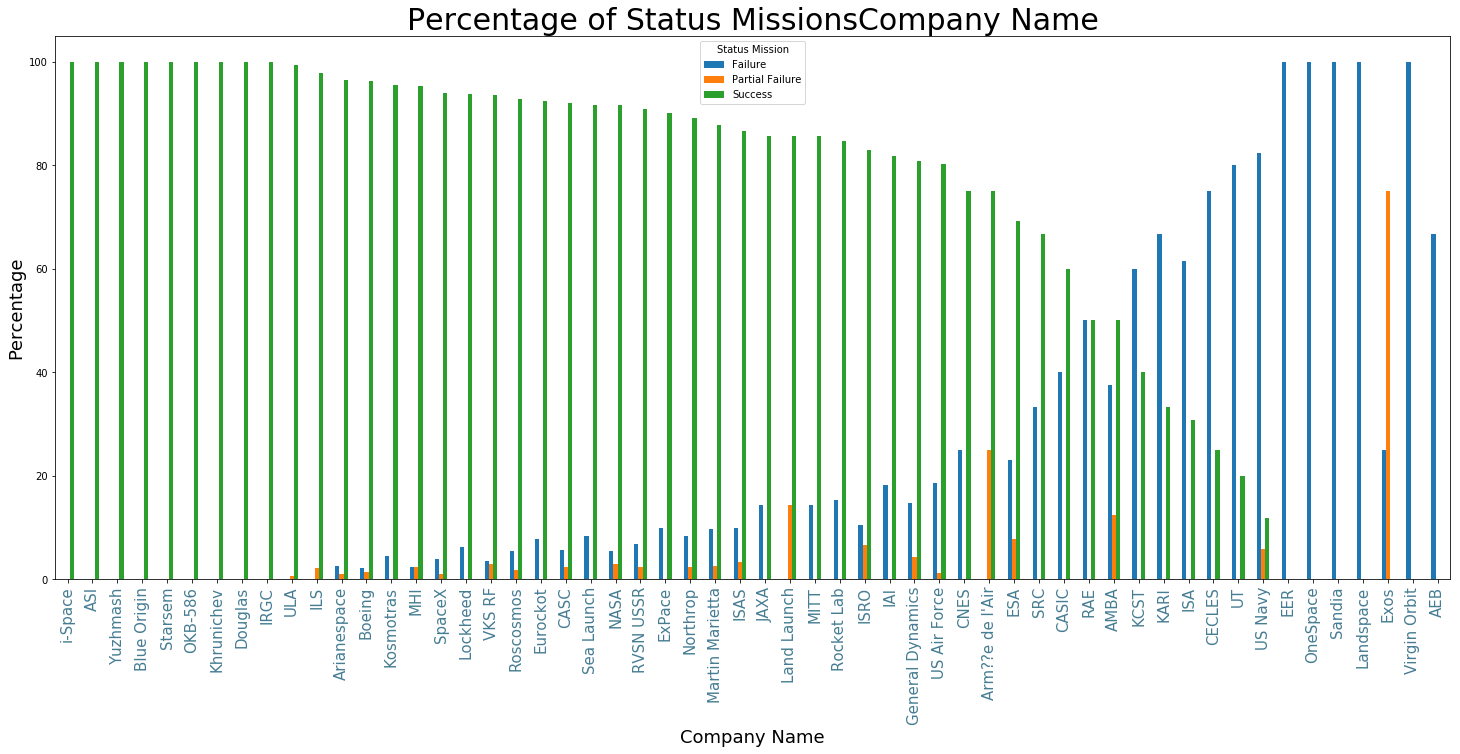

In [593]:
plot_mean('Company Name')

In [594]:
plot_mean2('Company Name')

### Plot Status Misi Terhadap Lokasi Stasiun

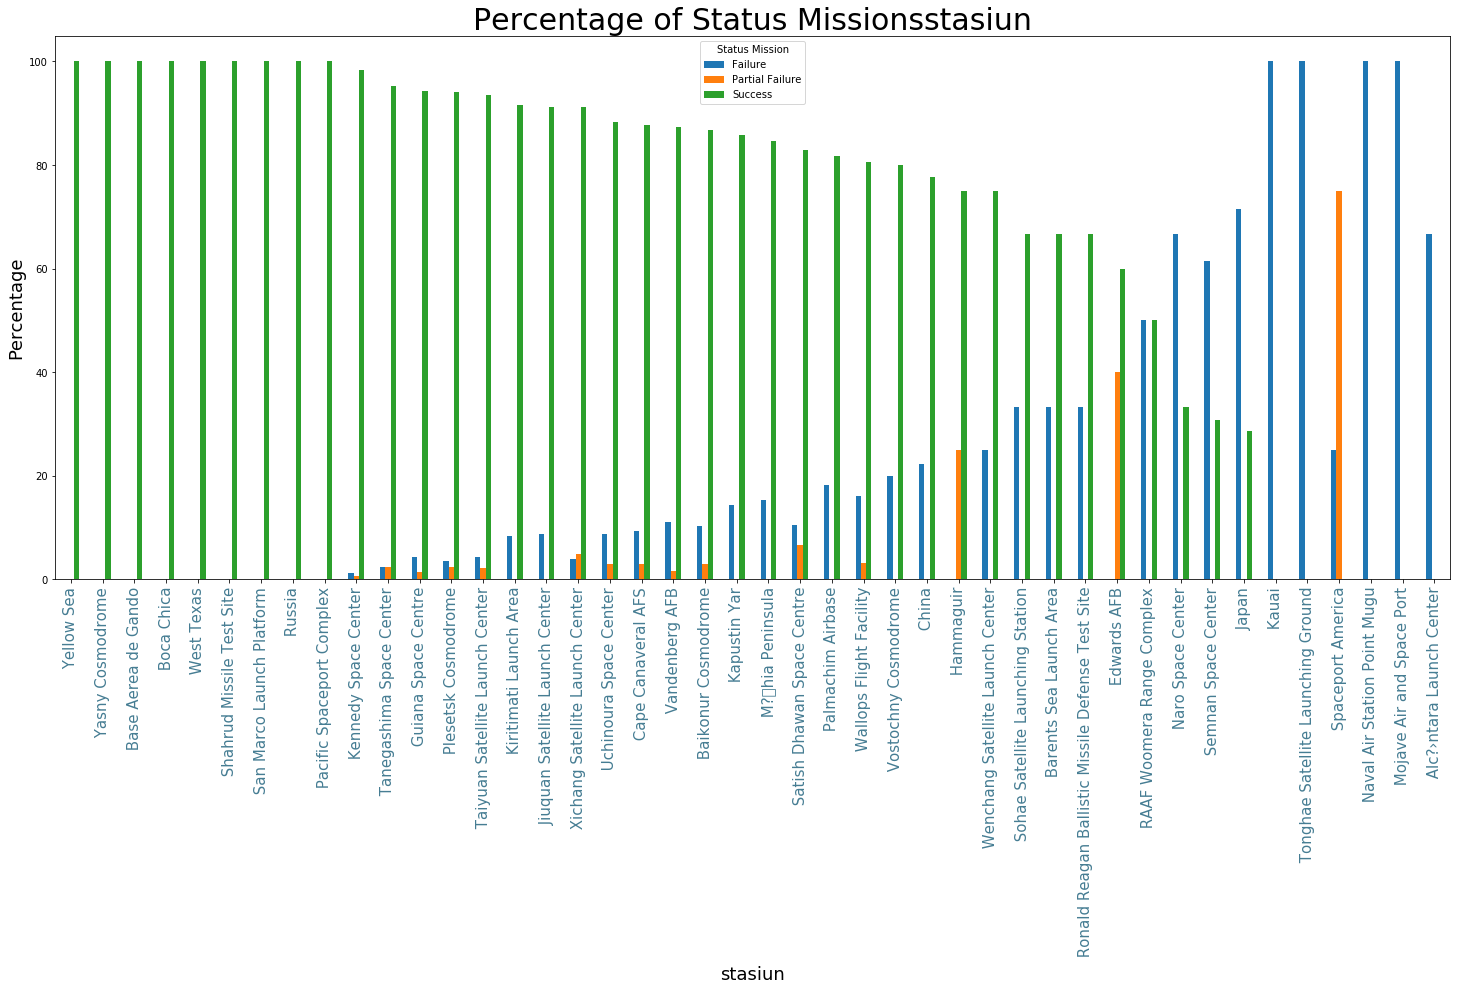

In [595]:
plot_mean('stasiun')

In [596]:
plot_mean2('stasiun')

### Analisis berdasarkan type

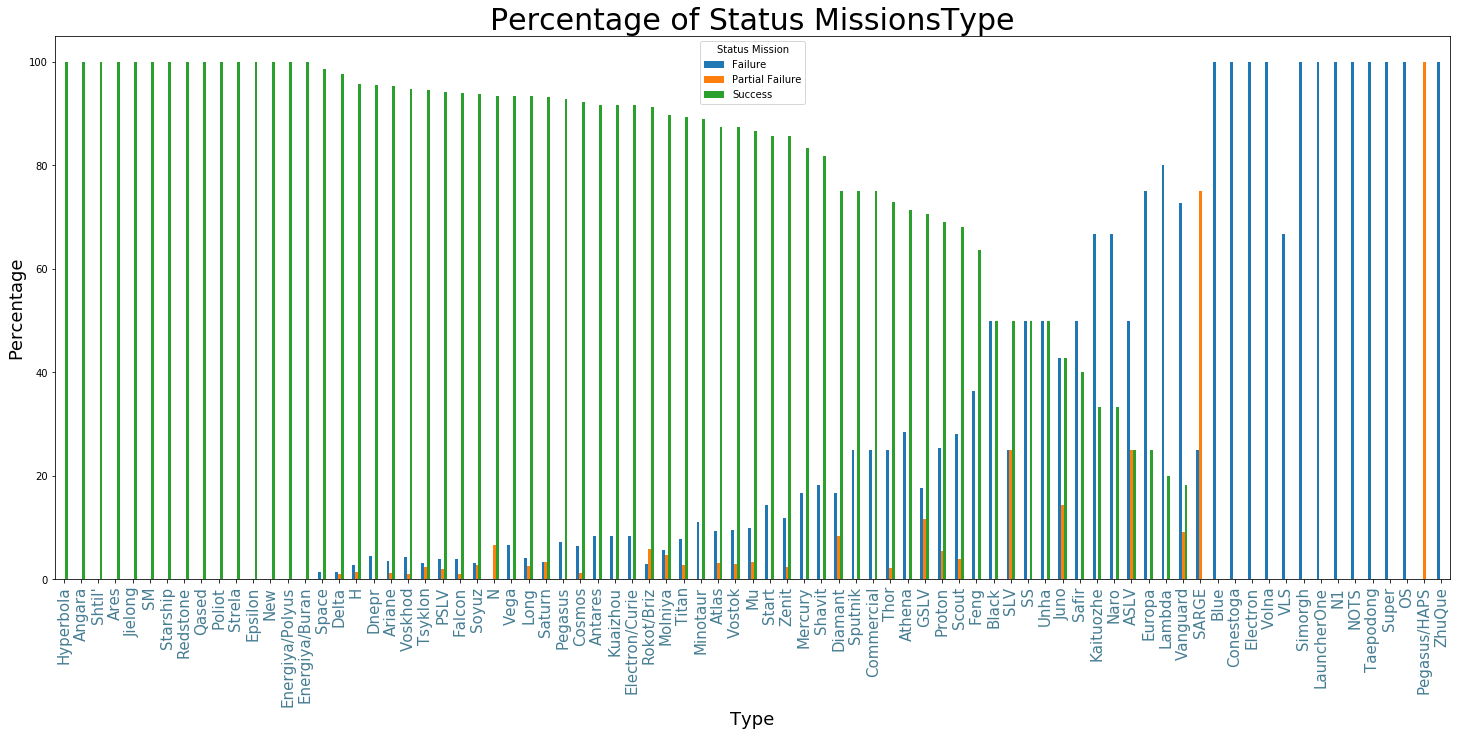

In [597]:
plot_mean('Type')

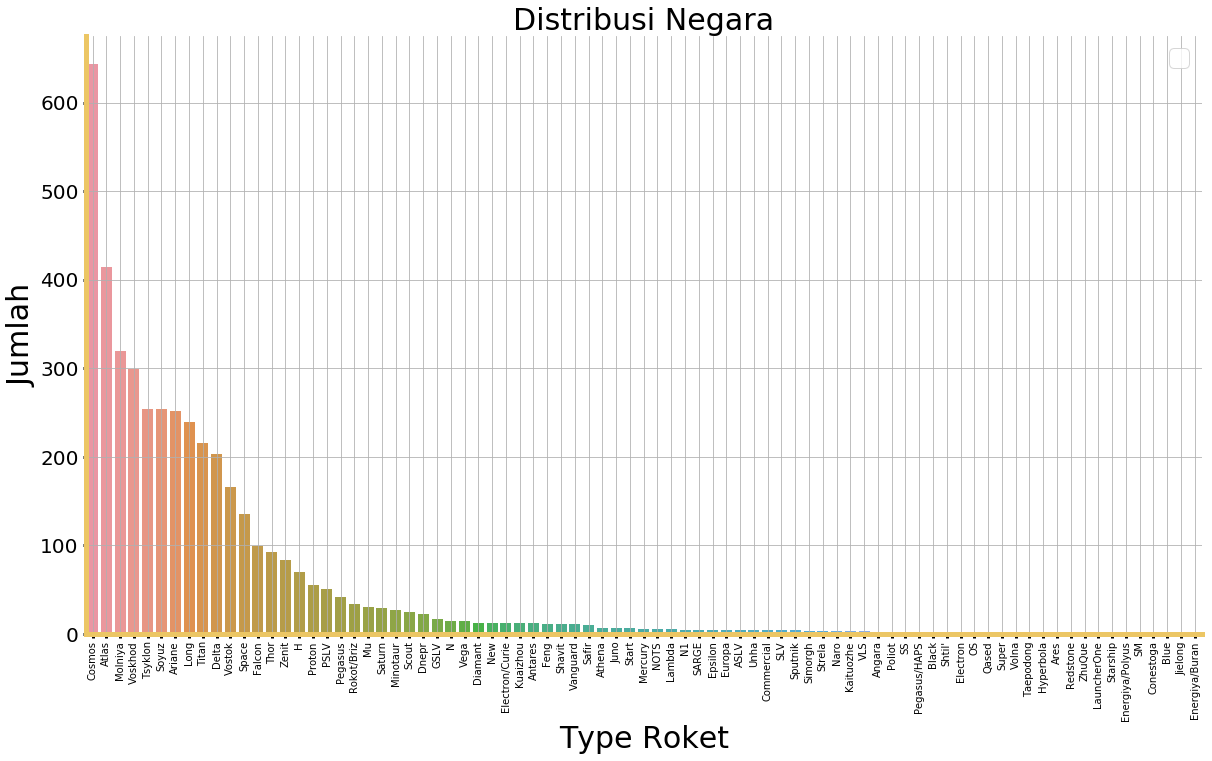

In [599]:
fig1 = plt.figure(figsize=(20,11))
ax = fig1

ax = sns.countplot(x = 'Type', data = df ,order = df['Type'].value_counts().index)

plt.xticks(rotation='vertical')

ax.set_xlabel('Type Roket', fontsize = 30)
ax.set_ylabel('Jumlah', fontsize = 30)
ax.set_title('Distribusi Negara',fontsize=30)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 20)

ax.legend(prop={'size': 25})
ax.grid(True)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('#ecc664')
ax.spines['bottom'].set_color('#ecc664')
ax.xaxis.set_tick_params(width=3)
ax.yaxis.set_tick_params(width=3)
plt.setp(ax.spines.values(), linewidth=5)

plt.xticks(rotation='vertical')
fig1.savefig('plot/dist_type.png', transparent=True, bbox_inches='tight')
plt.show()

### Plot Kegagalan Berdasarkan Tahun

In [557]:
def mean_time (date) :
    mean_ = df.groupby([date, 'Status Mission']).size().unstack(fill_value=0)
    mean_['Total'] = mean_.sum(axis=1)
    for i in range (0,4):
        mean_.iloc[:,i] = mean_.iloc[:,i]/mean_['Total'] *100
    return mean_

(array([1950., 1960., 1970., 1980., 1990., 2000., 2010., 2020.]),
 <a list of 8 Text xticklabel objects>)

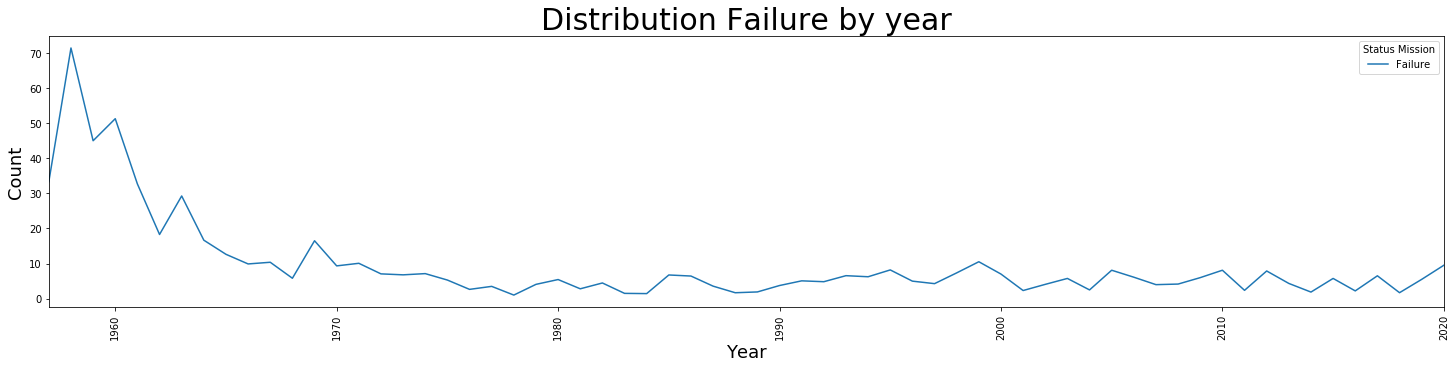

In [600]:
mean = mean_time('year')
ax = mean.iloc[:,[0]].plot.line(rot=0, figsize=(25,5))
ax.set_ylabel('Count', fontsize = 18)
ax.set_xlabel('Year', fontsize = 18)
ax.set_title('Distribution Failure by year',fontsize=30)
plt.savefig('plot/year.png', transparent=True, bbox_inches='tight')

plt.xticks(rotation='vertical')

### Plot Kegagalan Berdasarkan Bulan

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

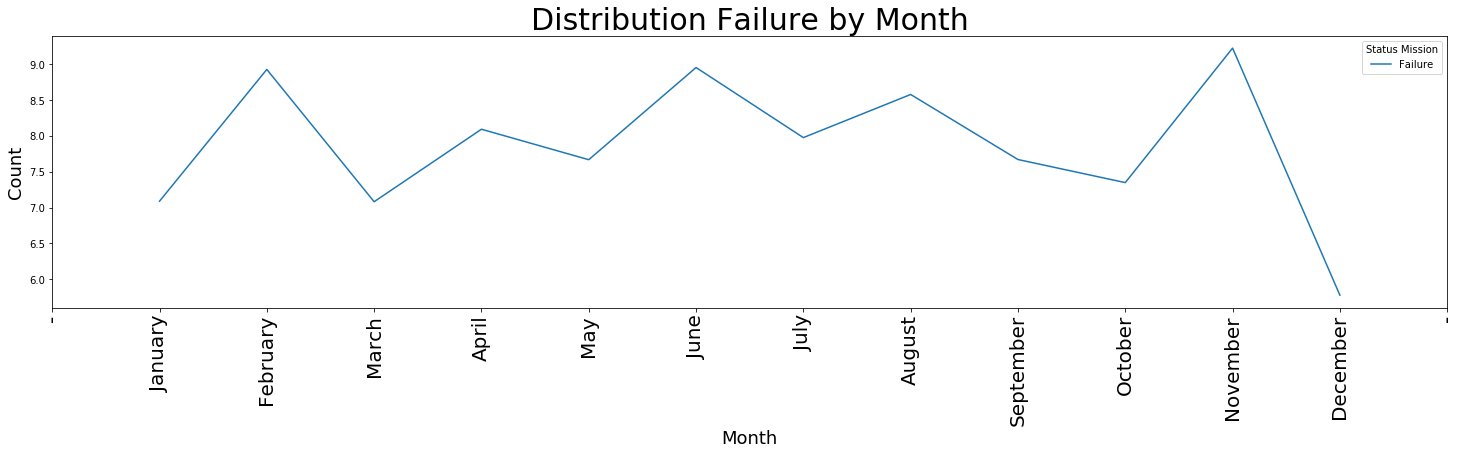

In [601]:
mean = mean_time('month')
ax = mean.iloc[:,[0]].plot.line(rot=0, figsize=(25,5))
x = ['-','January', 'February', 'March', 'April', 'May','June', 'July', 'August','September','October', 'November', 
     'December','-']
xi = list(range(len(x)))
ax.set_ylabel('Count', fontsize = 18)
ax.set_xlabel('Month', fontsize = 18)
ax.set_title('Distribution Failure by Month',fontsize=30)
plt.savefig('plot/Month.png', transparent=True, bbox_inches='tight')

plt.xticks(xi, x, fontsize = 20)

plt.xticks(rotation='vertical')

### Plot Biaya Peluncuran Berdasarkan Tahun

In [561]:
df[' Rocket'] = df[' Rocket'].apply(pd.to_numeric,errors='coerce')

mean_ = df.groupby('year').mean()

(array([1960., 1970., 1980., 1990., 2000., 2010., 2020.]),
 <a list of 7 Text xticklabel objects>)

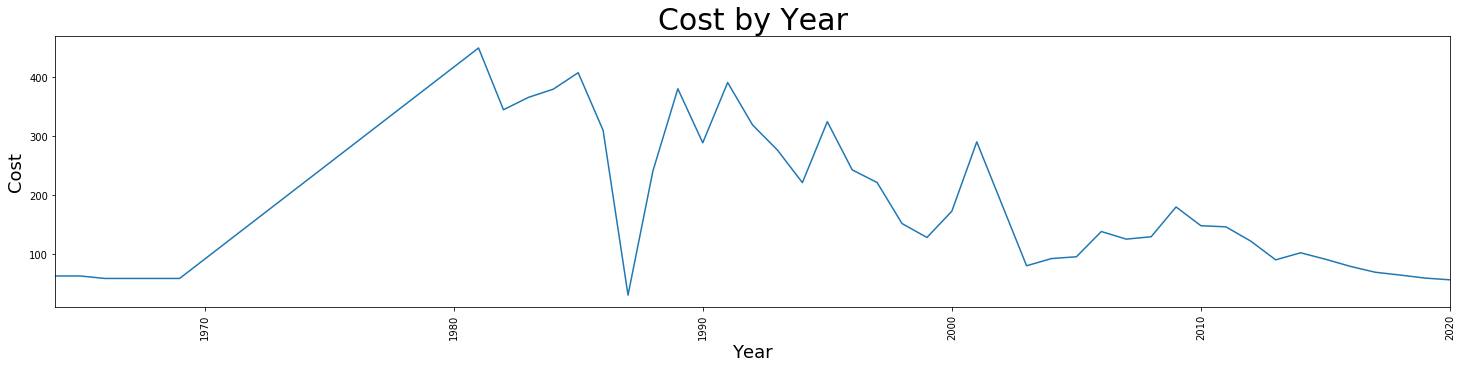

In [602]:
ax = mean_[' Rocket'][mean_[' Rocket'] > 0].plot.line(rot=0, figsize=(25,5))
ax.set_ylabel('Cost', fontsize = 18)
ax.set_xlabel('Year', fontsize = 18)
ax.set_title('Cost by Year',fontsize=30)
plt.savefig('plot/Cost.png', transparent=True, bbox_inches='tight')

plt.xticks(rotation='vertical')

In [563]:
df.head()

Company Name Status Rocket   Rocket Status Mission  \
0       SpaceX  StatusActive    50.00        Success   
1         CASC  StatusActive    29.75        Success   
2       SpaceX  StatusActive      NaN        Success   
3    Roscosmos  StatusActive    65.00        Success   
4          ULA  StatusActive   145.00        Success   

                            stasiun  year  month  days      Type      Country  
0              Kennedy Space Center  2020      8     7    Falcon          USA  
1   Jiuquan Satellite Launch Center  2020      8     6      Long        China  
2                        Boca Chica  2020      8     4  Starship          USA  
3               Baikonur Cosmodrome  2020      7    30    Proton   Kazakhstan  
4                Cape Canaveral AFS  2020      7    30     Atlas          USA

## Model

In [564]:
df[' Rocket'] = df[' Rocket'].fillna(0)

In [565]:
df['Target'] = (~(df['Status Mission'] == 'Success')).astype('int32')

In [566]:
df['Target'].unique()

array([0, 1], dtype=int64)

In [567]:
# definisi X dan y
X = df[['Company Name',' Rocket','Country', 'year', 'month', 'days', 'Type']]
encoder = LabelEncoder()
X.loc[:,'Company Name'] = encoder.fit_transform(X['Company Name'])
X.loc[:,'Country'] = encoder.fit_transform(X['Country'])
X.loc[:,'Type'] = encoder.fit_transform(X['Type'])
y = df['Target']

C:\Users\WIN 10\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [568]:
df_corr = X
df_corr['Status Mission'] = y

C:\Users\WIN 10\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



### Kolerasi antar variabel

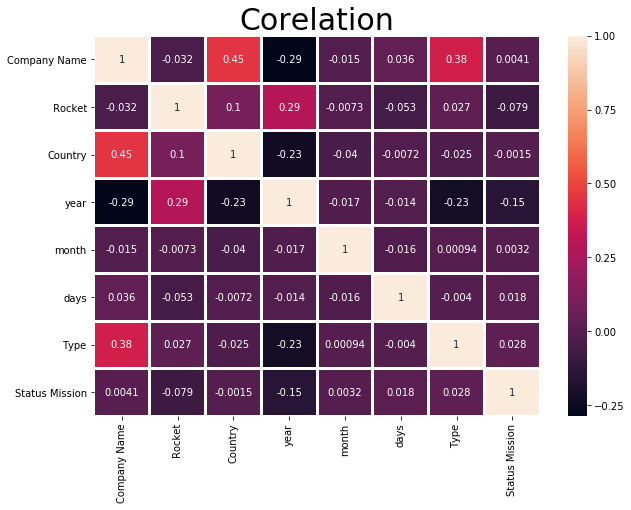

In [603]:
plt.figure(figsize=(10,7))
sns.heatmap(df_corr.corr(),annot=True,linewidths=2)
plt.savefig('k.png', transparent=True, bbox_inches='tight')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.title('Corelation',fontsize=30)
plt.savefig('plot/Cor.png', transparent=True, bbox_inches='tight')

### Split data

In [573]:
X = X[['Company Name',' Rocket','Country', 'year', 'month', 'days', 'Type']]

In [574]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### XG Boost

In [575]:
classifier_xgb = xgb.XGBClassifier(random_state = 30, n_jobs = -1,max_depth = 5)
model = classifier_xgb.fit(X_train,y_train)

In [576]:
print(f'Training Accuracy is {accuracy_score(y_train, classifier_xgb.predict(X_train))*100:.2f}%')
print(f'Testing Accuracy is {accuracy_score(y_test, classifier_xgb.predict(X_test))*100:.2f}%')

Training Accuracy is 95.63%
Testing Accuracy is 90.75%


<Figure size 432x288 with 0 Axes>

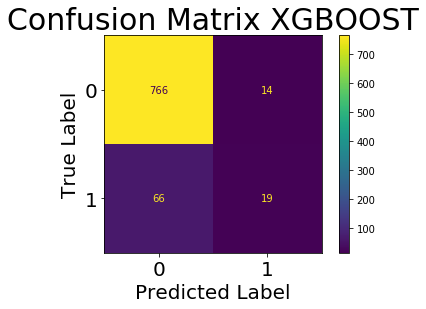

In [604]:
from sklearn.metrics import confusion_matrix

fig = plt.figure()

ax = plot_confusion_matrix(model, X_test, y_test)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('Predicted Label', fontsize = 20)
plt.ylabel('True Label', fontsize = 20)
plt.title('Confusion Matrix XGBOOST',fontsize=30)
plt.savefig('plot/xgboost.png', transparent=True, bbox_inches='tight')

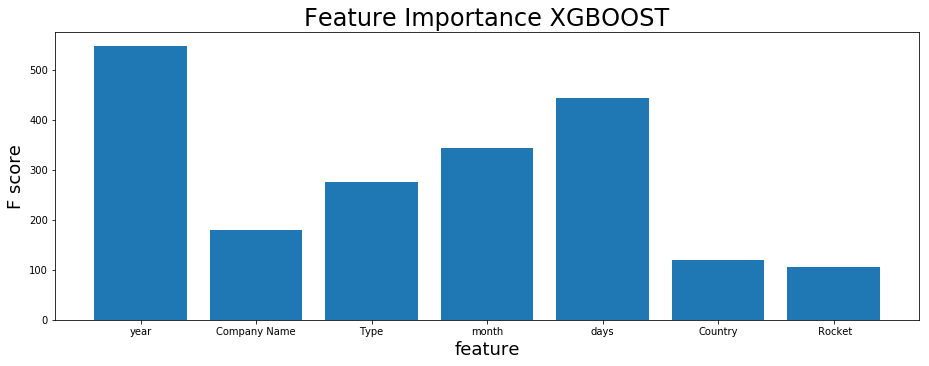

In [605]:
fig1 = plt.figure()
ax = fig1.add_axes([0, 0, 2, 1])

ax.bar(list(feature_importance_xgb.keys()), list(feature_importance_xgb.values()))
ax.set_xlabel('feature', fontsize = 18)
ax.set_ylabel('F score', fontsize = 18)
ax.set_title('Feature Importance XGBOOST', fontsize = 24)
fig1.savefig('plot/cf_xgboost.png', transparent=True, bbox_inches='tight')

### Random Forest

In [581]:
classifier_rf = RandomForestClassifier(random_state = 30, n_jobs = -1,max_depth = 5)
clf=classifier_rf.fit(X_train,y_train)

In [582]:
print(f'Training Accuracy is {accuracy_score(y_train, classifier_rf.predict(X_train))*100:.2f}%')
print(f'Testing Accuracy is {accuracy_score(y_test, classifier_rf.predict(X_test))*100:.2f}%')

Training Accuracy is 90.40%
Testing Accuracy is 90.75%


<Figure size 432x288 with 0 Axes>

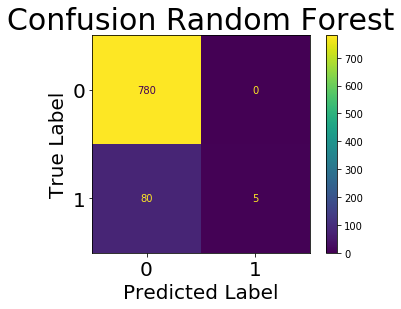

In [607]:
from sklearn.metrics import confusion_matrix

fig = plt.figure()

ax = plot_confusion_matrix(clf, X_test, y_test)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('Predicted Label', fontsize = 20)
plt.ylabel('True Label', fontsize = 20)
plt.title('Confusion Random Forest',fontsize=30)
plt.savefig('plot/Random Forest.png', transparent=True, bbox_inches='tight')

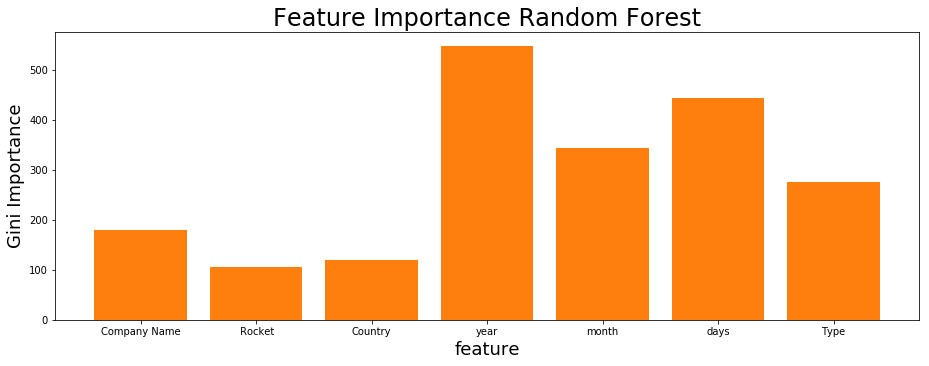

In [608]:
fig1 = plt.figure()
ax = fig1.add_axes([0, 0, 2, 1])

ax.bar(list(X_train.columns), list(classifier_rf.feature_importances_))
ax.bar(list(feature_importance_xgb.keys()), list(feature_importance_xgb.values()))
ax.set_xlabel('feature', fontsize = 18)
ax.set_ylabel('Gini Importance', fontsize = 18)
ax.set_title('Feature Importance Random Forest', fontsize = 24)
plt.savefig('plot/cf_Random Forest.png', transparent=True, bbox_inches='tight')

### Decision Tree

In [515]:
from sklearn.tree import DecisionTreeClassifier
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()
# Train Decision Tree Classifer
clf.fit(X_train,y_train)

DecisionTreeClassifier()

In [516]:
y_pred = clf.predict(X_test)

print(f'Testing Accuracy is {accuracy_score(y_test, y_pred)*100:.2f}%')

Testing Accuracy is 84.05%


<Figure size 432x288 with 0 Axes>

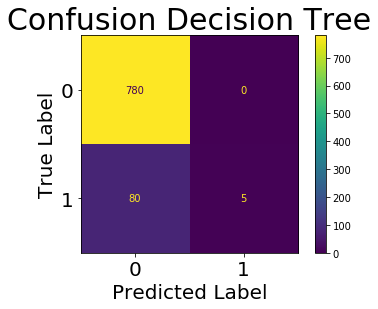

In [609]:
from sklearn.metrics import confusion_matrix

fig = plt.figure()

ax = plot_confusion_matrix(clf, X_test, y_test)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('Predicted Label', fontsize = 20)
plt.ylabel('True Label', fontsize = 20)
plt.title('Confusion Decision Tree',fontsize=30)
plt.savefig('plot/Decision Tree.png', transparent=True, bbox_inches='tight')

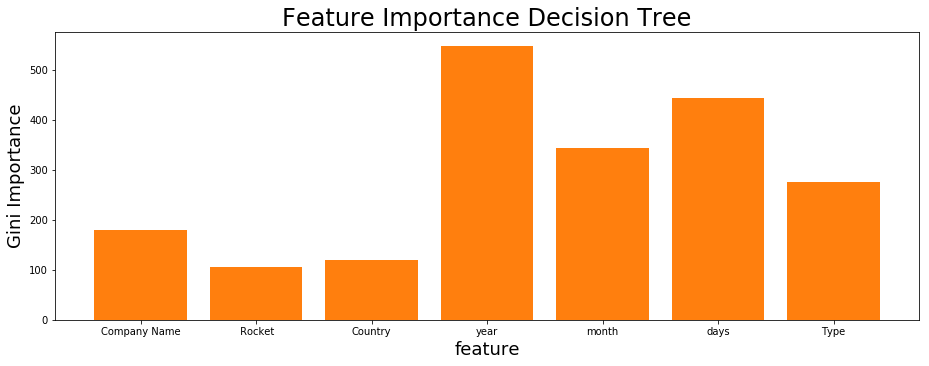

In [610]:
fig1 = plt.figure()
ax = fig1.add_axes([0, 0, 2, 1])

ax.bar(list(X_train.columns), list(clf.feature_importances_))
ax.bar(list(feature_importance_xgb.keys()), list(feature_importance_xgb.values()))
ax.set_xlabel('feature', fontsize = 18)
ax.set_ylabel('Gini Importance', fontsize = 18)
ax.set_title('Feature Importance Decision Tree', fontsize = 24)
plt.savefig('plot/cf_Decision Tree.png', transparent=True, bbox_inches='tight')